In [1]:
import sys
from baselines.intersection_based.inter_models import *
from baselines.utils.common_utils import seed_everything, get_device
from baselines.utils.inter_utils import *
import pandas as pd
import os
import torch
from torch.utils.data import DataLoader, Dataset
device = get_device()
import warnings
warnings.filterwarnings("ignore")

Using GPU


In [2]:
#Settings
#Instead of using argparse set the arguments here
min_size = 300
max_size = 500
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
class settings:
    dataframe = "ACPDS/ACPDS/ACPDS_dataframe.csv"
    path =  "ACPDS/ACPDS"
    model_type = "faster_rcnn_vgg"
    batch_size = 8

In [3]:
seed_everything(seed=420)
args = settings()

if args.model_type == 'faster_rcnn_mobilenet':
    model = get_model(faster_rcnn_mobilenet_params)
elif args.model_type == 'faster_rcnn_resnet':
    model = get_model(faster_rcnn_resnet_params)
elif args.model_type == 'faster_rcnn_vgg':
    model = get_model(faster_rcnn_vgg_params)
elif args.model_type == 'retinanet_mobilenet':
    model = get_model(retinanet_mobilenet_params)
elif args.model_type == 'retinanet_resnet':
    model = get_model(retinanet_resnet_params)
elif args.model_type == 'retinanet_vgg':
    model = get_model(retinanet_vgg_params)
else:
    raise Exception('Invalid model type')

model.to(device);

In [4]:
DIR_INPUT = os.path.join(args.path, 'splitted_images/')
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_VAL = f'{DIR_INPUT}/val'
DIR_TEST = f'{DIR_INPUT}/test'

dataframe = pd.read_csv(args.dataframe)

train_df, valid_df = get_dataframes(dataframe)

# dataloaders
train_dataset = ParkDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = ParkDataset(valid_df, DIR_VAL, get_valid_transform())

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()
train_data_loader = DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    #num_workers=4,
    collate_fn=collate_fn
)
valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    #num_workers=4,
    collate_fn=collate_fn
)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler_increase = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=10.0)
lr_scheduler_decrease = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 50

train_inter_model(model, num_epochs, train_data_loader, valid_data_loader, device)

# Inference

In [ ]:
def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    plt.axis("off")
    annotation["boxes"] = annotation["boxes"].cpu()
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 2 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

Using GPU


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


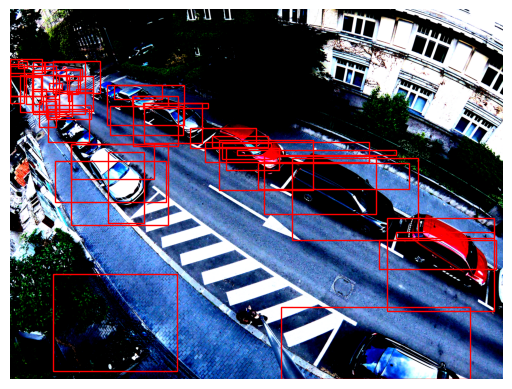

In [ ]:
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches


device = get_device()
model = torch.load("Saved_Models/34.pth")
image = cv2.imread("GOPR6551.jpg", cv2.IMREAD_COLOR).astype(np.float32)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0

preprocess = transforms.Compose([
    # convert the frame to a CHW torch tensor for training
    transforms.ToTensor(),
    # normalize the colors to the range that mobilenet_v2/3 expect
    transforms.Normalize(mean=mean, std=std),
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

with torch.no_grad():
    input_batch = input_batch.to(device)
    pred = make_prediction(model, input_batch, 0.6)
plot_image_from_output(input_tensor, pred[0])

